To run a cell, type `Shift` + `Return`. Run the cell below to get started

In [18]:
from workshop_utils import * 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import geopandas as gpd
import shapely
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm_notebook as tqdm
tqdm().pandas();

# Puerto Rico Example


The following query gets all of the edits (ever), joined to changesets for all objects in Puerto Rico... it should take some time to download.

```sql
SELECT
  central_america.id, 
  geom,
  central_america.tags, changeset, updated, valid_until, version, minor_version,
  changesets.id AS c_id, 
  changesets.tags as c_tags,
  changesets.uid,
  changesets.user
  
FROM central_america

JOIN changesets on central_america.changeset = changesets.id

WHERE ST_WITHIN(
  geom , 
  ST_POLYGON('POLYGON((-67.3066 18.5729, -65.5553 18.5729, -65.5553 17.8729, -67.3066 17.8729, -67.3066 18.5729))'))
ORDER BY updated
```

In [2]:
# edits = load_dataframe_from_s3('https://us-east-2.console.aws.amazon.com/athena/query/results/116fe037-6c95-4517-b52b-de3ecc3ba763/csv')
#edits = load_dataframe_from_s3('https://us-east-2.console.aws.amazon.com/athena/query/results/5e4ea35a-0c61-4a79-8af0-77e18612ed13/csv')
edits = load_dataframe_from_s3('https://us-east-2.console.aws.amazon.com/athena/query/results/45b14013-55ee-49a3-98e2-6fb47e45302d/csv')


45b14013-55ee-49a3-98e2-6fb47e45302d.csv
Creating dataframe... done.  Found 374,801 rows

In [3]:
place = "NW Puerto Rico"

In [4]:
edits.head(2)

,id,geom,tags,changeset,updated,valid_until,version,minor_version,c_id,c_tags,uid,user
0,53200463,POINT (-66.9724524 18.4951852),{created_by=JOSM},454478,2007-09-17 10:20:25.000,2008-12-13 23:42:48.000,1,0,454478,{},10019,Xaa
1,53200466,POINT (-67.0147075 18.5142),{created_by=JOSM},454478,2007-09-17 10:20:25.000,2008-12-13 23:42:48.000,1,0,454478,{},10019,Xaa


In [5]:
#Cast the date as date
edits['updated'] = edits.updated.progress_apply(pd.Timestamp)
edits['date'] = edits.updated.progress_apply(pd.Timestamp.date)

In [6]:
gb_date = edits.groupby('date').aggregate({
    'c_id':'count',
    'id':'nunique',
    'uid':'nunique'
});
gb_date.head(2)

,c_id,id,uid
date,,,
2007-09-17,9,9,1
2008-01-16,1531,1531,1


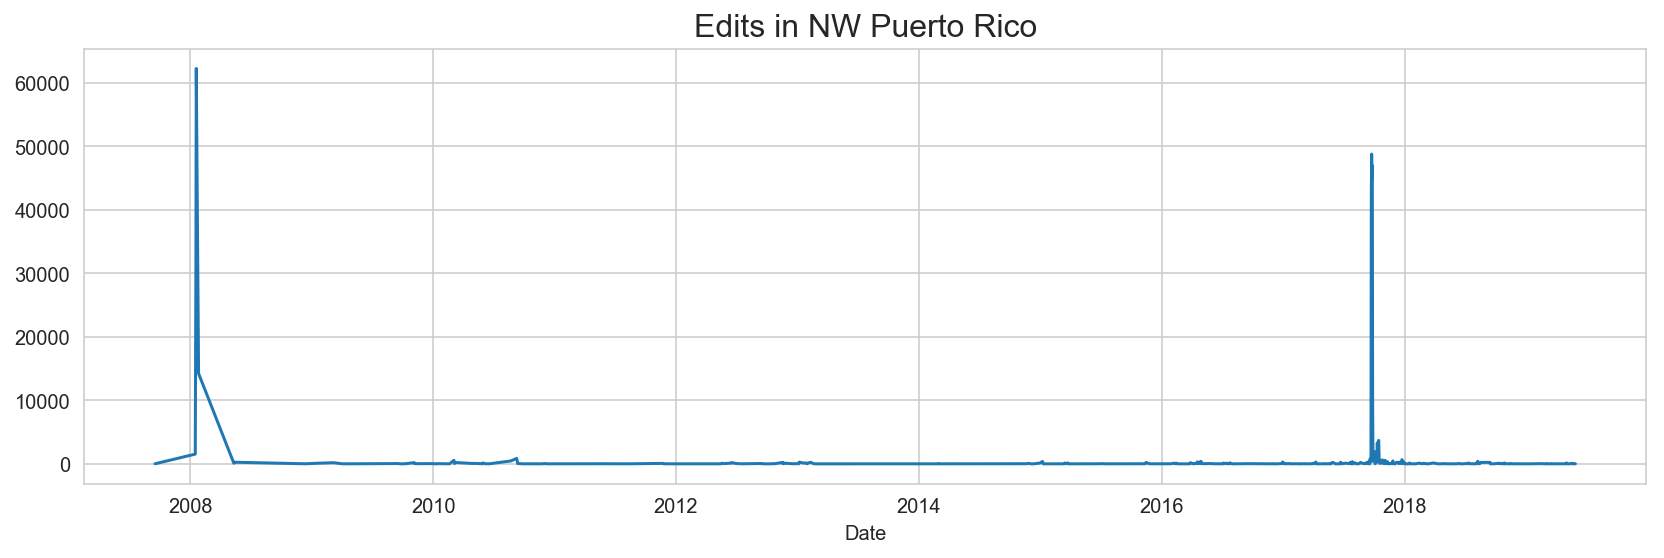

In [7]:
sns.set_style('whitegrid')
ax = gb_date['c_id'].plot(figsize=(14,4))
ax.set_xlabel("Date"); ax.set_ylabel("");
ax.set_title("Edits in {}".format(place),fontsize=16);

### Question: What's the spike in 2007? 

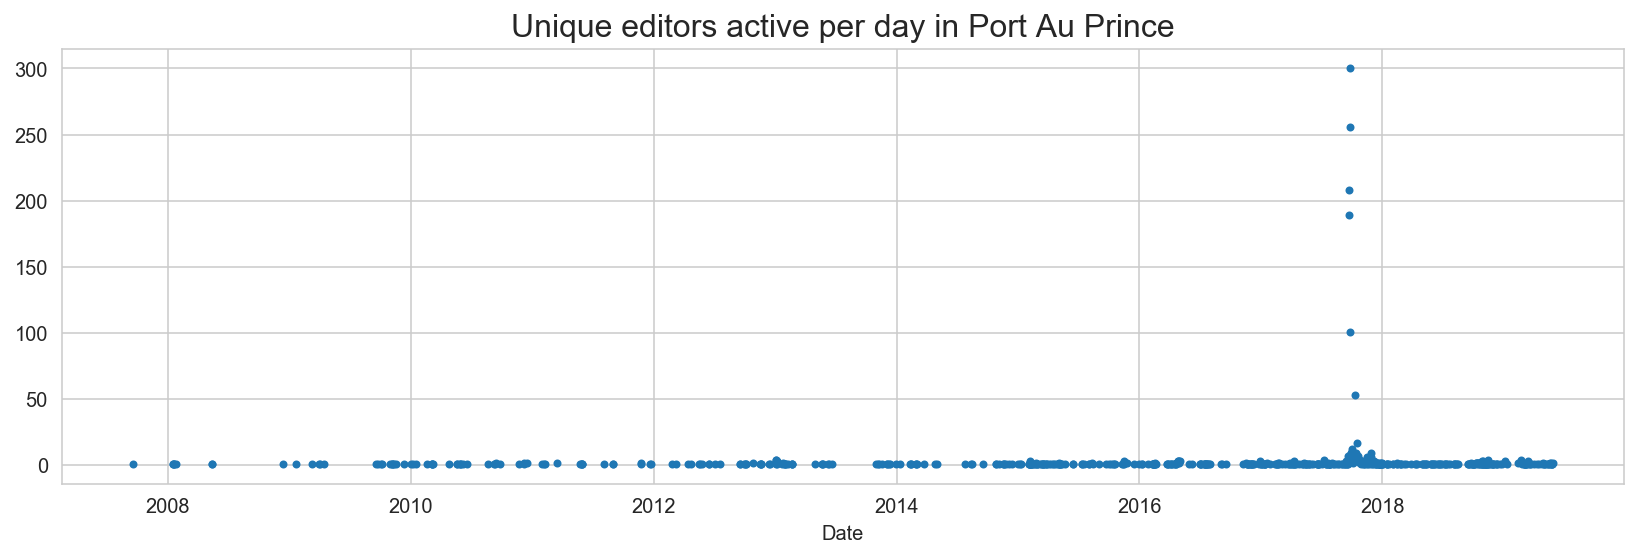

In [8]:
sns.set_style('whitegrid')
ax = gb_date['uid'].plot(style='.', figsize=(14,4))
ax.set_xlabel("Date"); ax.set_ylabel("");
ax.set_title("Unique editors active per day in Port Au Prince",fontsize=16);

### Note, there is no user spike in 2007...

In [9]:
after_tiger = edits[edits.updated > datetime.datetime(2010,1,1)]

In [10]:
from shapely import wkt

In [12]:
sample2 = after_tiger.sample(10000) #just sample 100k objects

In [13]:
sample2.geom = sample2.geom.progress_apply(wkt.loads)

In [19]:
sample2['date'] = sample2.updated.apply(lambda x: x.isoformat())

In [20]:
objects = gpd.GeoDataFrame(sample2, geometry='geom')

In [21]:
from keplergl import KeplerGl 
map_1 = KeplerGl(height=600)
map_1

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(height=600)

In [22]:
map_1.add_data(data=objects[['geom','changeset','date','user']], name='objects')

## Make it interactive

From the sidebar on the left, add a filter to the 'objects' layer on 'date'

Also, set layer blending to "normal" to highlight where the most edits are happening